**Our main goal:** Check the hypothesis that the first convolutional layer in an object detection model performs edge detection among other feature extraction tasks.

**Our tasks:**
1. Analyze learned kernel weights of the first convolutional layer in the [SSD head detection](https://github.com/AVAuco/ssd_head_keras) model. Carry on a convolution operation on an example image using the retrieved kernel weights sand analyze the results.
2. Run a simple edge detection model based on Sobel filter using TensorFlow functional API. Test it on few example images to see the basics of edge detection.

Importing libraries

In [ ]:
import os
import shutil
import gdown
import urllib.request
import h5py

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Lambda


from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

<h2>Task 1</h2>

Downloading the model weights (weights are stored in a Google Drive Storage and explicit info is avalaible [here](https://github.com/AVAuco/ssd_head_keras/blob/master/data/download_model_py3.6.sh) )

In [ ]:
url = 'https://drive.google.com/uc?id=1vlmKOBtaT7eAd4_WcAv5MLBn7q_SWXoh'
output = 'ssd512-hollywood-trainval-bs_16-lr_1e-05-scale_pascal-epoch-187-py3.6.h5'
gdown.download(url, output, quiet=False)
!ls

Downloading...
From: https://drive.google.com/uc?id=1vlmKOBtaT7eAd4_WcAv5MLBn7q_SWXoh
To: /content/ssd512-hollywood-trainval-bs_16-lr_1e-05-scale_pascal-epoch-187-py3.6.h5
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


sample_data
ssd512-hollywood-trainval-bs_16-lr_1e-05-scale_pascal-epoch-187-py3.6.h5


Check the model weights file

In [ ]:
f = h5py.File(output, 'r')
print(f.keys())
print(f['model_weights'])
print(f['model_weights'].keys())

<KeysViewHDF5 ['model_weights']>
<HDF5 group "/model_weights" (113 members)>
<KeysViewHDF5 ['conv10_1', 'conv10_2', 'conv10_2_mbox_conf', 'conv10_2_mbox_conf_reshape', 'conv10_2_mbox_loc', 'conv10_2_mbox_loc_reshape', 'conv10_2_mbox_priorbox', 'conv10_2_mbox_priorbox_reshape', 'conv10_padding', 'conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv4_1', 'conv4_2', 'conv4_3', 'conv4_3_norm', 'conv4_3_norm_mbox_conf', 'conv4_3_norm_mbox_conf_reshape', 'conv4_3_norm_mbox_loc', 'conv4_3_norm_mbox_loc_reshape', 'conv4_3_norm_mbox_priorbox', 'conv4_3_norm_mbox_priorbox_reshape', 'conv5_1', 'conv5_2', 'conv5_3', 'conv6_1', 'conv6_2', 'conv6_2_mbox_conf', 'conv6_2_mbox_conf_reshape', 'conv6_2_mbox_loc', 'conv6_2_mbox_loc_reshape', 'conv6_2_mbox_priorbox', 'conv6_2_mbox_priorbox_reshape', 'conv6_padding', 'conv7_1', 'conv7_2', 'conv7_2_mbox_conf', 'conv7_2_mbox_conf_reshape', 'conv7_2_mbox_loc', 'conv7_2_mbox_loc_reshape', 'conv7_2_mbox_priorbox', 'conv7_2_mbox_prior

We will analyse the `conv1_1` as it is the first convolutional layer in the SSD model (see [model architecture definition](https://github.com/AVAuco/ssd_head_keras/blob/master/models/keras_ssd512.py))

In [ ]:
conv_layer = f['model_weights']['conv1_1']['conv1_1']
kernels = conv_layer['kernel:0']
biases = conv_layer['bias:0']
print("Conv2D layer kernel dims: ",kernels.shape)
print("Conv2D layer biases dims: ",biases.shape)

Conv2D layer kernel dims:  (3, 3, 3, 64)
Conv2D layer biases dims:  (64,)


In [ ]:
R_filters=kernels[0]
G_filters=kernels[1]
B_filters=kernels[2]
print("Red color filter dims:", R_filters.shape)
print("Green color filter dims:", G_filters.shape)
print("Blue color filter dims:", B_filters.shape)

Red color filter dims: (3, 3, 64)
Green color filter dims: (3, 3, 64)
Blue color filter dims: (3, 3, 64)


In [ ]:
np.round(R_filters[:,:,1], 2)

array([[ 0.12,  0.02, -0.17],
       [ 0.16,  0.05, -0.17],
       [ 0.13,  0.04, -0.15]], dtype=float32)

Lets plot the kernels for every color channel

In [ ]:
def plot_grid(data, n_col=8, pic_size=1, background_color=(1,1,1,), alpha=(1,)):

  n_row = len(data)//n_col
  # Configure plot and disable axis
  fig, ax = plt.subplots(n_row,n_col, figsize=(n_col*pic_size,n_row*pic_size))
  fig.set_facecolor( background_color + alpha )

  for i in range(len(data)):
    ax[i//n_col][i%n_col].set_axis_off()
    fig.add_axes(ax[i//n_col][i%n_col])
    ax[i//n_col][i%n_col].imshow(data[i],interpolation="nearest",cmap="gray")
    current_axis = plt.gca()

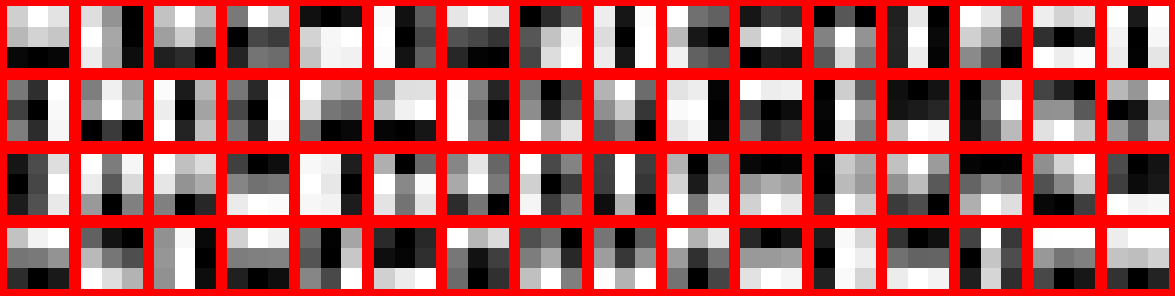

In [ ]:
r_data = [R_filters[:,:,i] for i in range(R_filters.shape[-1])]
plot_grid(r_data, n_col=16, pic_size=1.3,background_color=(1,0,0))

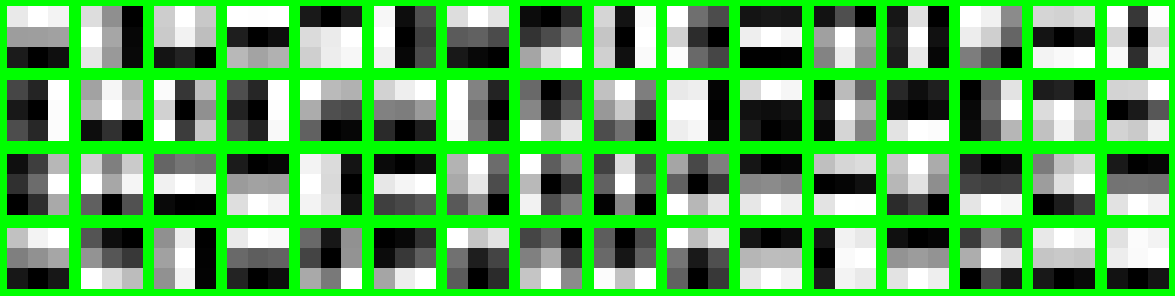

In [ ]:
g_data = [G_filters[:,:,i] for i in range(G_filters.shape[-1])]
plot_grid(g_data, n_col=16, pic_size=1.3,background_color=(0,1,0))

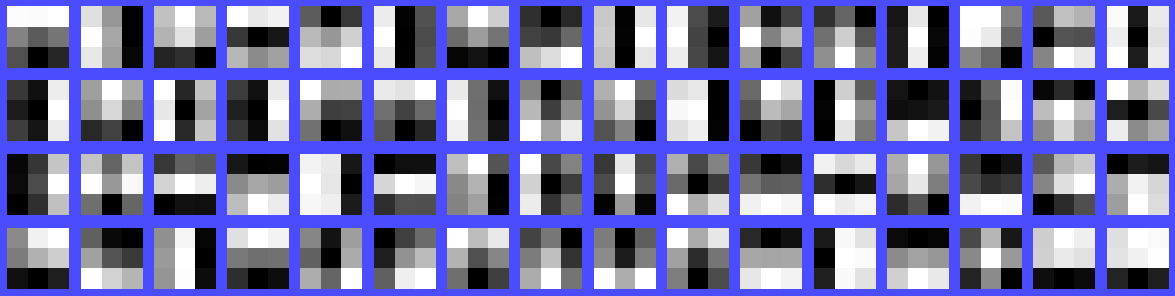

In [ ]:
b_data = [B_filters[:,:,i] for i in range(B_filters.shape[-1])]
plot_grid(b_data, n_col=16, pic_size=1.3,background_color=(0,0,1),alpha=(0.7,))

We can see, that kernels are visually familiar to different variety of edge detection filters (for example [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator)). For clarity, we will filter a RGB image with these kernels to visualise the effects.

Download an image from web

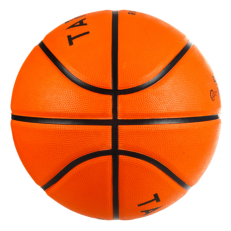

In [ ]:
# define paths
url="https://contents.mediadecathlon.com/p1549971/k$173033bb6fb1dacf0eee35ab75dd7940/kids-slashadult-size-7-basketball-r100-orange.jpg"
save_folder = 'imgs'
if not os.path.exists(save_folder):
  os.mkdir(save_folder)

# Download the image
n_files =len(os.listdir(save_folder))
file_name = save_folder + "/fig{}.".format(n_files+0)  + url.split(".")[-1]
urllib.request.urlretrieve(url, file_name)

# Plot the image
with Image.open(file_name) as im:
  plt.imshow(im)
  plt.axis('off')

Create a Conv2D layer and initialize it with our weights

In [ ]:
filter_layer = Conv2D(kernels.shape[-1], (kernels.shape[-3],kernels.shape[-2]), padding='same',use_bias=False,weights=[kernels])

Load an image and filter it with the filter_layer

In [ ]:
im = tf.keras.utils.load_img(file_name) 
im = tf.convert_to_tensor( np.array(im), dtype=tf.float32)
im = tf.image.resize(im, (512,512)) #resize the image to default size of the model input
im = tf.expand_dims(im,axis=0)
im = im/tf.reduce_max(im)
print("Image shape:", im.shape)

im_out = filter_layer(im)
print("Output shape:", im_out.shape)

Image shape: (1, 512, 512, 3)
Output shape: (1, 512, 512, 64)


Lets visualize the filtering results

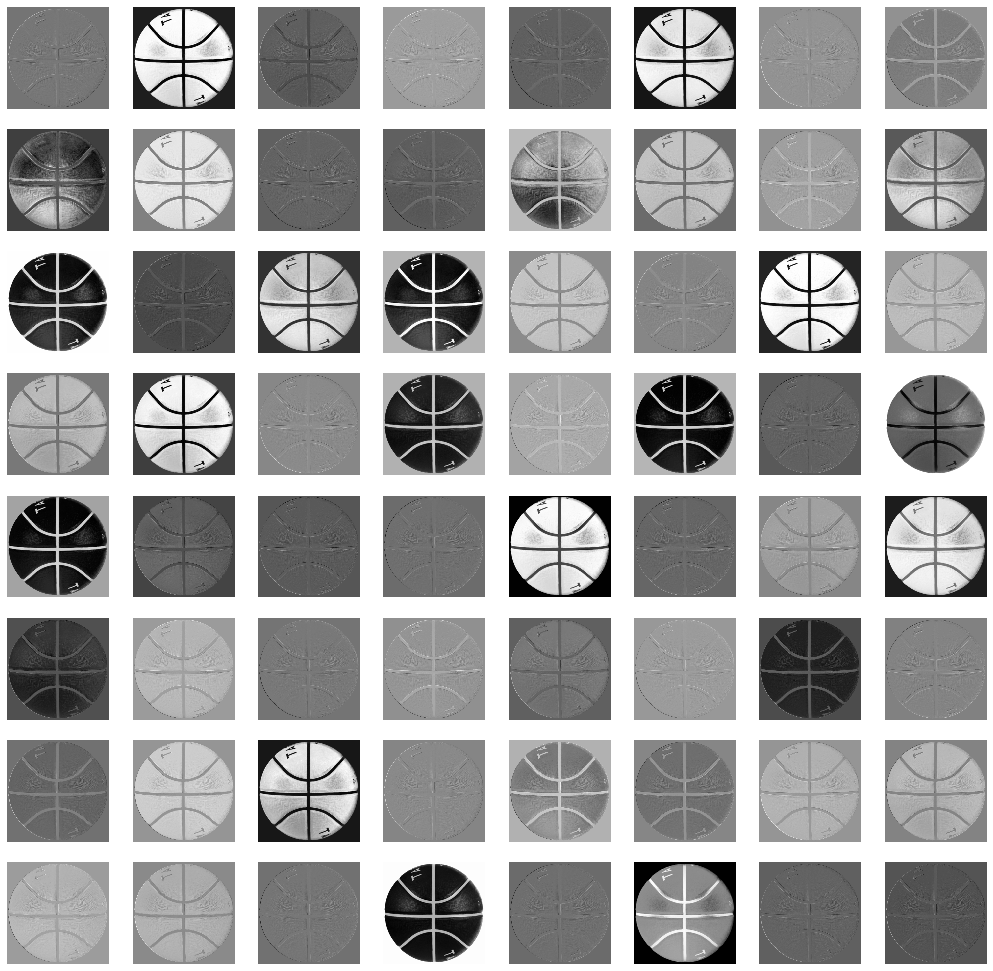

In [ ]:
im_out = tf.squeeze(im_out)
im_data = [im_out[:,:,i] for i in range(im_out.shape[-1])]
plot_grid(im_data, n_col=8, pic_size=2.2)

We see a wast variety of features extracted from the RGB image. Few of them represent corners of a ball present in the image.

<h2> Task 2 </h2>

We will build a corner extracition model based on Sobel filters using TensorFlow 'Functional API'

In [ ]:
def get_model(thrsh = None):

  # Initializing Sobel filters
  sobel_x = tf.constant( [[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]])
  sobel_y = tf.constant( [[-1, -2, -1],
                          [ 0,  0,  0],
                          [ 1,  2,  1]]) 
  sobel_x = tf.expand_dims( tf.expand_dims(sobel_x, axis=-1), axis=-1)
  sobel_y = tf.expand_dims( tf.expand_dims(sobel_y, axis=-1), axis=-1)

  # Defining model layers
  inputs = tf.keras.Input(shape=(None,None,1),name='Input')
  sx = Conv2D(filters=1,kernel_size=(3,3), padding='same',use_bias=False,weights=[sobel_x])(inputs)
  sy = Conv2D(filters=1,kernel_size=(3,3), padding='same',use_bias=False,weights=[sobel_y])(inputs)
  mag = Lambda(lambda x: tf.math.sqrt(tf.math.add( tf.math.pow(x[0],2), tf.math.pow(x[1],2) )))((sx,sy))

  if thrsh is not None:
    outputs = Lambda(lambda x: tf.cast(x > thrsh, tf.float32) )(mag)
  else:
    outputs = mag

  return tf.keras.Model(inputs=inputs, outputs=outputs)

Generating two models: with a threshold and without.

In [ ]:
sobel = get_model()
sobel_thrsh = get_model(0.4)

Downloading additional images and stacking them together into Tensor 

In [ ]:
# define paths
urls = [
'https://ae01.alicdn.com/kf/HTB176e4aN_rK1RkHFqDq6yJAFXaO/Black-White-Chess-Board-Chess-Pieces-photo-backdrop-High-quality-Computer-print-wall-background.jpg_Q90.jpg',
'https://addtocartaustralia.com.au/wp-content/uploads/2020/10/Cybertruck-opinion_dezeen_sq.jpg',
'https://i.ytimg.com/vi/ROKYbgGUNvQ/maxresdefault.jpg',
'https://www.oregonlive.com/resizer/QTi1nU1IBj1scEYi66A7nf8yhxA=/1280x0/smart/advancelocal-adapter-image-uploads.s3.amazonaws.com/image.oregonlive.com/home/olive-media/width2048/img/hg_impact/photo/butterfly1jpg-2bd6d3f52fbf6f14.jpg']

save_folder = 'imgs'
if not os.path.exists(save_folder):
  os.mkdir(save_folder)

# Download the image
for url in urls:
  n_files =len(os.listdir(save_folder))
  file_name = save_folder + "/fig{}.".format(n_files+0)  + url.split(".")[-1]
  urllib.request.urlretrieve(url, file_name)

imgs = []
# Stacking images into Tensor
for i, img_name in enumerate(os.listdir(save_folder)):
  im = tf.keras.utils.load_img(os.path.join(save_folder,img_name)) 
  im = tf.convert_to_tensor( np.array(im), dtype=tf.float32)
  im = tf.image.rgb_to_grayscale(im)
  im = tf.image.resize(im, (512,512)) 
  im = im/tf.reduce_max(im)
  imgs.append(im)

imgs = tf.convert_to_tensor( np.array(imgs), dtype=tf.float32)
imgs.shape

TensorShape([5, 512, 512, 1])

Calculating edges of our images

In [ ]:
sobel_out = sobel.predict( imgs )
sobel_thrsh_out = sobel_thrsh.predict(imgs)

Plotting the results

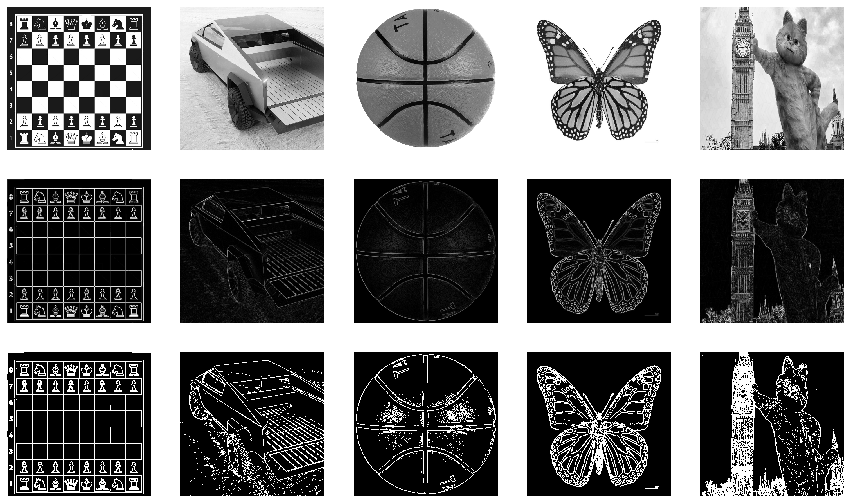

In [ ]:
data = tf.concat([imgs, sobel_out, sobel_thrsh_out],axis=0)
data = [ tf.squeeze(data[i]) for i in range(data.shape[0])]
plot_grid(data, n_col=5, pic_size=3)

**Conclusions:** 

1. We saw that the first convolutional layer in the [SSD head detection model](https://github.com/AVAuco/ssd_head_keras) functions as an edge detector.
2. Using classical Sobel filters one can fairly easily detect object edges in a given image. 